In [2]:
import tensorflow as tf
import numpy as np
import audiosegment
import pandas as pd

print(tf.__version__)


2.6.0


# Data


In [3]:
audio_sample_rate = 16000
audio_sample_dur_s = 0.5
model_sample_length = int(audio_sample_rate * audio_sample_dur_s)
audio_sample_rate, audio_sample_dur_s, model_sample_length

(16000, 0.5, 8000)

In [42]:
import audiosegment

audio_map = {}  # filename: normalised audiosegment.
input_audio_file_paths = [
    "C:\\temp\\temp_test_annotationpro_ws\\samples\\202107140827.wav",
    "C:\\temp\\temp_test_annotationpro_ws\\samples\\202107140837.wav",
    "C:\\temp\\temp_test_annotationpro_ws\\samples\\202107140840.wav",
    "C:\\temp\\temp_test_annotationpro_ws\\samples\\202108250841.wav",
]
for input_audio_file_path in input_audio_file_paths:
    input_audio_segment = audiosegment.from_file(input_audio_file_path)
    print(f"Original sample rate: {input_audio_segment.seg.frame_rate}")
    print(f"Original sample width: {input_audio_segment.seg.sample_width}")
    print(f"Original frame width: {input_audio_segment.seg.frame_width}")
    print(f"Duration (seconds): {input_audio_segment.seg.duration_seconds}")
    input_audio_segment_resampled = input_audio_segment.resample(
        channels=1, sample_rate_Hz=16000, sample_width=2
    )

    pcm_int16 = np.frombuffer(input_audio_segment_resampled.seg.raw_data, dtype=np.int16)
    pcm_float32 = pcm_int16.astype(dtype=np.float32)
    int16_iinfo = np.iinfo(np.int16)
    # pcm_float32_normalised = (
    #     2.0 * (pcm_float32 - np.min(pcm_float32)) / np.ptp(pcm_float32) - 1
    # )
    # pcm_float32_intminmax_normalised = (
    #     2.0 * (pcm_float32 - int16_iinfo.min) / (int16_iinfo.max - int16_iinfo.min) - 1
    # )
    pcm_float32_normalised = np.interp(
        pcm_float32,
        (np.min(pcm_float32), np.max(pcm_float32)),
        (-1.0, 1.0),
    )
    pcm_float32_normalised = pcm_float32_normalised.astype(np.float32)
    pcm_float32_intminmax_normalised = np.interp(
        pcm_float32,
        (int16_iinfo.min, int16_iinfo.max),
        (-1.0, 1.0),
    )
    pcm_float32_intminmax_normalised = pcm_float32_intminmax_normalised.astype(np.float32)

    audio_map[os.path.basename(input_audio_file_path)] = pcm_float32_intminmax_normalised

pad = lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros(i - a.shape[0], dtype=np.float32)))


Original sample rate: 16000
Original sample width: 2
Original frame width: 2
Duration (seconds): 308.736
Original sample rate: 16000
Original sample width: 2
Original frame width: 2
Duration (seconds): 327.552
Original sample rate: 16000
Original sample width: 2
Original frame width: 2
Duration (seconds): 206.784
Original sample rate: 16000
Original sample width: 2
Original frame width: 2
Duration (seconds): 218.114


In [33]:
import xml.etree.ElementTree as ET
from typing import Sequence, Set
from sklearn.model_selection import train_test_split
from collections import defaultdict


class AnnotationLayer:
    label: str = None
    layer_node = None
    layer_id: str = None
    segments: Sequence = None
    audio_file_node = None
    audio_filename: str = None

    def __init__(self, layer_node):
        self.label = layer_node.find("ns:Name", ns).text.lower().strip()
        self.layer_id = layer_node.find("ns:Id", ns).text
        self.layer_node = layer_node
        self.segments = []

    def __str__(self) -> str:
        return f'("{self.label}", "{self.layer_id}")'

    def __repr__(self) -> str:
        return str(self)


class AudioSegmentInfo:
    segment_node = None
    id: str = None
    layer_id: str = None
    begin_sample: float = 0
    duration_sample: float = 0
    pcm_normalised = None
    audio_filename: str = None
    label: str = None

    def __init__(self, segment_node):
        self.segment_node = segment_node
        self.id = self.segment_node.find("ns:Id", ns)
        self.layer_id = self.segment_node.find("ns:IdLayer", ns).text
        self.begin_sample = float(self.segment_node.find("ns:Start", ns).text)
        self.duration_sample = float(self.segment_node.find("ns:Duration", ns).text)
        self.end_sample = self.begin_sample + self.duration_sample

    def __str__(self) -> str:
        return f'("{self.label}", "{self.begin_sample}, {self.duration_sample}")'

    def __repr__(self) -> str:
        return str(self)


class MlAudioSample:
    pcm_normalised = None
    labels: Set[str] = None

    def __init__(self):
        self.labels = set()


xmlns = "http://tempuri.org/AnnotationSystemDataSet.xsd"
ns = {
    "ns": xmlns,
}
input_annotation_paths = [
    "C:\\temp\\temp_test_annotationpro_ws\\202107140827.antx",
    "C:\\temp\\temp_test_annotationpro_ws\\202107140837.antx",
    # "C:\\temp\\temp_test_annotationpro_ws\\202107140840.antx",
    "C:\\temp\\temp_test_annotationpro_ws\\202108250841.antx",
]

layers = {}
for input_annotation_path in input_annotation_paths:
    tree = ET.parse(input_annotation_path)
    troot = tree.getroot()

    for layer in troot.iterfind("ns:Layer", ns):
        ml_cls = AnnotationLayer(layer_node=layer)
        ml_cls.audio_file_node = troot.find("ns:AudioFile", ns)
        ml_cls.audio_filename = ml_cls.audio_file_node.find("ns:Name", ns).text
        layers[ml_cls.layer_id] = ml_cls

    for segment in troot.iterfind("ns:Segment", ns):
        seg_info = AudioSegmentInfo(segment_node=segment)
        class_info = layers[seg_info.layer_id]
        class_info.segments.append(seg_info)

        sample_begin = int(seg_info.begin_sample)
        sample_end = int(seg_info.begin_sample + seg_info.duration_sample)
        # seg_info.pcm_normalised = pcm_float32_normalised[sample_begin:sample_end]
        seg_info.pcm_normalised = audio_map[class_info.audio_filename][
            sample_begin:sample_end
        ]
        seg_info.label = class_info.label

        # seg_info.pcm_normalised = pad(seg_info.pcm_normalised, model_sample_length)


X = []
y = []
label_idx_map = {}
label_idx = 0
for _, layer in layers.items():
    # print(f'Processing "{layer.label}" label')
    if layer.label not in label_idx_map:
        label_idx_map[layer.label] = label_idx
        label_idx += 1
    label_val = label_idx_map[layer.label]
    for seg_info in layer.segments:
        seg_pcm = seg_info.pcm_normalised
        # print(seg_pcm.shape[0])
        if seg_pcm.shape[0] >= model_sample_length:
            idx = 0
            while (idx + model_sample_length) <= seg_pcm.shape[0]:
                new_pcm = seg_pcm[idx : idx + model_sample_length]
                assert not np.any(np.isnan(new_pcm))
                X.append(new_pcm)
                y.append(label_val)
                idx += 500
                # break
        else:
            new_pcm = pad(seg_pcm, model_sample_length)
            assert not np.any(np.isnan(new_pcm))
            X.append(new_pcm)
            y.append(label_val)


idx_label_map = [None] * len(label_idx_map)
for lbl, idx in label_idx_map.items():
    idx_label_map[idx] = lbl

print(f"{len(X)} number of training data.")
for _, layer in layers.items():
    print(f'"{layer.label}": {len(layer.segments)}')
print(f"label index map: {label_idx_map}")


X = np.asarray(X)
y = np.asarray(y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

X_v2 = []
y_v2 = []
label_v2_sample_cnts = defaultdict(lambda: 0)
label_segment_map = {}  # maps label to all segments for that label.
for filename, file_audio_seg in audio_map.items():
    audio_file_layers = [
        layer for _, layer in layers.items() if layer.audio_filename == filename
    ]
    label_seg_info_set = []
    for layer in audio_file_layers:
        label_seg_info_set += layer.segments
    # print(label_seg_info_set)

    # print(filename, audio_file_layers)
    seg_idx = 0
    while seg_idx < file_audio_seg.shape[0]:
        sub_seg_end = seg_idx + model_sample_length
        file_sub_seg = file_audio_seg[seg_idx:sub_seg_end]
        file_sub_seg = pad(file_sub_seg, model_sample_length)
        seg_idx += 1000

        matching_label_seg_info_set = [
            a
            for a in label_seg_info_set
            if (
                seg_idx >= a.begin_sample
                and seg_idx < a.end_sample
            )
            or (
                sub_seg_end >= a.begin_sample
                and sub_seg_end < a.end_sample
            )
        ]
        if not matching_label_seg_info_set:
            continue

        seg_class_labels = set()
        for mlsi in matching_label_seg_info_set:
            seg_class_labels.add(mlsi.label)

        one_hot_vec = np.zeros(len(label_idx_map))
        for seg_info in matching_label_seg_info_set:
            for lbl in seg_class_labels:
                one_hot_vec[label_idx_map[lbl]] = 1
                label_v2_sample_cnts[lbl] += 1  # Increment label sample counter.

        X_v2.append(file_sub_seg)
        y_v2.append(one_hot_vec)


X_v2 = np.asarray(X_v2)
y_v2 = np.asarray(y_v2, dtype=np.float32)
X_v2_train, X_v2_test, y_v2_train, y_v2_test = train_test_split(
    X_v2, y_v2, test_size=0.33, random_state=42
)

print(f"{X_v2.shape[0]} v2 training samples.")
print(f"v2 label counts: {label_v2_sample_cnts}")


3137 number of training data.
"sound": 194
"dog": 90
"gromit": 2
"silence": 14
"sound": 126
"dog": 68
"gromit": 10
label index map: {'sound': 0, 'dog': 1, 'gromit': 2, 'silence': 3}
3391 v2 training samples.
v2 label counts: defaultdict(<function <lambda> at 0x0000015184FCD820>, {'dog': 4789, 'sound': 4951, 'silence': 868, 'gromit': 683})


# Model (Sparse Categorical)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                80010     
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 44        
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 20        
Total params: 80,094
Trainable params: 80,094
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
66/66 [==============================] - 1s 5ms/step - loss: 1.3571 - accuracy: 0.3403 - val_loss: 1.3596 - val_accuracy: 0.3118
Epoch 2/100
66/66 [==============================] - 0s 4ms/step - loss: 1.3428 - accuracy: 0.3403 - val_lo

<AxesSubplot:title={'center':'Model History'}>

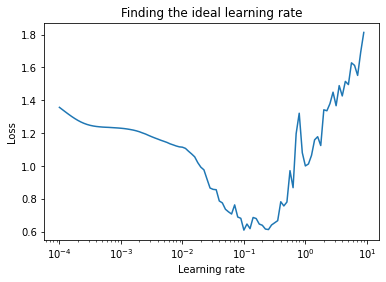

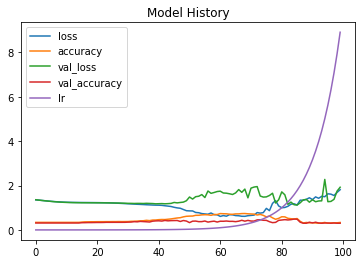

In [8]:
model_test = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(model_sample_length,)),
        tf.keras.layers.Dense(10, activation="sigmoid"),
        tf.keras.layers.Dense(4, activation="sigmoid"),
        tf.keras.layers.Dense(4, activation="sigmoid"),
        tf.keras.layers.Dense(len(label_idx_map), activation="softmax"),
    ]
)

model_test.compile(
    optimizer=tf.keras.optimizers.Adam(),
    # optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model_test.summary()

# Create the learning rate callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10 ** (epoch / 20)
)

epochs = 100
history_test = model_test.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    callbacks=[lr_scheduler]
)

import matplotlib.pyplot as plt

lrs = 1e-4 * (10 ** (np.arange(epochs) / 20))
plt.semilogx(lrs, history_test.history["loss"])  # want the x-axis to be log-scale
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Finding the ideal learning rate")

pd.DataFrame(history_test.history).plot(title="Model History")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 200)               1600200   
_________________________________________________________________
dense_13 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_14 (Dense)             (None, 25)                2525      
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 104       
Total params: 1,622,929
Trainable params: 1,622,929
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
66/66 [==============================] - 1s 5ms/step - loss: 1.2733 - accuracy: 0.3370 - val_loss: 1.2402 - val_accuracy: 0.3166
Epoch 2/100
66/66 [==============================] - 0s 4ms/step - loss: 1.2197 - accuracy: 0.3308 - 

<AxesSubplot:title={'center':'Model History'}>

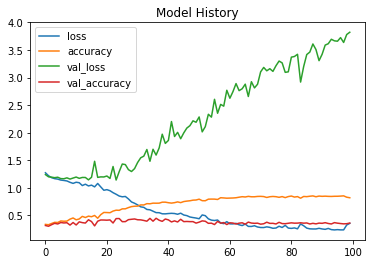

In [10]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(model_sample_length)),
        tf.keras.layers.Dense(200, activation="sigmoid"),
        tf.keras.layers.Dense(100, activation="sigmoid"),
        tf.keras.layers.Dense(25, activation="sigmoid"),
        tf.keras.layers.Dense(len(label_idx_map), activation="softmax"),
    ]
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
    # optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.summary()

epochs = 100
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
)

pd.DataFrame(history.history).plot(title="Model History")


In [11]:

print(X.shape)
result = model.predict(np.asarray([X[0]]))
print(result)

(3137, 8000)
[[1.6668520e-03 9.9831510e-01 1.7536158e-05 5.5149326e-07]]


# Model V2 (Categorical)


[-2.2888533e-04 -1.0681315e-04  1.6784924e-04  2.8992142e-04
  1.6784924e-04  4.5777066e-05  1.0681315e-04  4.5777066e-05
  1.5259022e-05  1.6784924e-04]
[[0. 0. 0. 1.]
 [1. 1. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 0. 0. 0.]]
['sound', 'dog', 'gromit', 'silence']


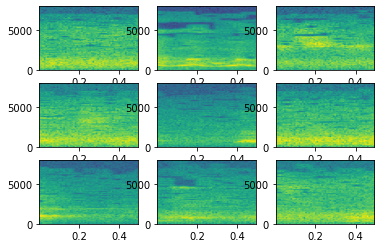

In [12]:
# Plot spectrogram of a random training sample
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram

fig, (ax, ax2, ax3) = plt.subplots(3,3)
ax[0].specgram(X_v2_train[0], Fs=audio_sample_rate)
ax[1].specgram(X_v2_train[1], Fs=audio_sample_rate)
ax[2].specgram(X_v2_train[2], Fs=audio_sample_rate)
ax2[0].specgram(X_v2_train[3], Fs=audio_sample_rate)
ax2[1].specgram(X_v2_train[4], Fs=audio_sample_rate)
ax2[2].specgram(X_v2_train[5], Fs=audio_sample_rate)
ax3[0].specgram(X_v2_train[6], Fs=audio_sample_rate)
ax3[1].specgram(X_v2_train[7], Fs=audio_sample_rate)
ax3[2].specgram(X_v2_train[8], Fs=audio_sample_rate)
print(X_v2[0][:10])
print(y_v2_train[0:10])
print(idx_label_map)
# specgram(X_v2[1], Fs=audio_sample_rate)
# specgram(X_v2[2], Fs=audio_sample_rate)
# specgram(X_v2[3], Fs=audio_sample_rate)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 192)               1536192   
_________________________________________________________________
dense_17 (Dense)             (None, 192)               37056     
_________________________________________________________________
dense_18 (Dense)             (None, 192)               37056     
_________________________________________________________________
dense_19 (Dense)             (None, 192)               37056     
_________________________________________________________________
dense_20 (Dense)             (None, 4)                 772       
Total params: 1,648,132
Trainable params: 1,648,132
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
71/71 [==============================] - 1s 6ms/step - loss: 2.3846 - accuracy: 0.0000e+00 - catego

<AxesSubplot:title={'center':'Model History'}>

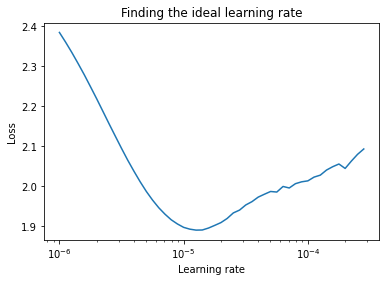

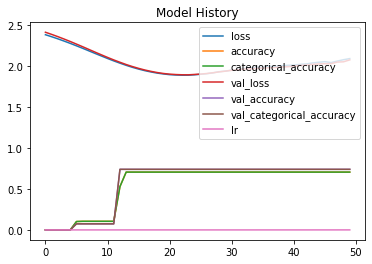

In [13]:
model_v2_test = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(model_sample_length,)),
        tf.keras.layers.Dense(192, activation="sigmoid"),
        tf.keras.layers.Dense(192, activation="sigmoid"),
        tf.keras.layers.Dense(192, activation="sigmoid"),
        tf.keras.layers.Dense(192, activation="sigmoid"),
        tf.keras.layers.Dense(len(label_idx_map), activation="softmax"),
    ]
)

model_v2_test.compile(
    optimizer=tf.keras.optimizers.Adam(),
    # optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy", tf.keras.metrics.CategoricalAccuracy()],
)

model_v2_test.summary()

# Create the learning rate callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10 ** (epoch / 20)
)

epochs = 50
history_v2_test = model_v2_test.fit(
    X_v2_train,
    y_v2_train,
    validation_data=(X_v2_test, y_v2_test),
    epochs=epochs,
    callbacks=[lr_scheduler],
)
# print(history_v2_test.history)

import matplotlib.pyplot as plt

lrs = 1e-6 * (10 ** (np.arange(epochs) / 20))
plt.semilogx(lrs, history_v2_test.history["loss"])  # want the x-axis to be log-scale
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Finding the ideal learning rate")

pd.DataFrame(history_v2_test.history).plot(title="Model History")


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 1600)              12801600  
_________________________________________________________________
dense_27 (Dense)             (None, 1600)              2561600   
_________________________________________________________________
dense_28 (Dense)             (None, 1600)              2561600   
_________________________________________________________________
dense_29 (Dense)             (None, 1600)              2561600   
_________________________________________________________________
dense_30 (Dense)             (None, 4)                 6404      
Total params: 20,492,804
Trainable params: 20,492,804
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [==============================] - 1s 9ms/step - loss: 2.3604 - accuracy: 0.5601 - categor

<AxesSubplot:title={'center':'Model History'}>

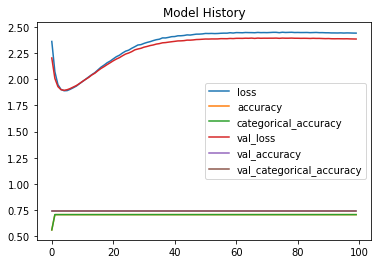

In [15]:
model_v2 = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(model_sample_length,)),
        tf.keras.layers.Dense(1600, activation="sigmoid"),
        tf.keras.layers.Dense(1600, activation="sigmoid"),
        tf.keras.layers.Dense(1600, activation="sigmoid"),
        tf.keras.layers.Dense(1600, activation="sigmoid"),
        tf.keras.layers.Dense(len(label_idx_map), activation="softmax"),
    ]
)

model_v2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    # optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy", tf.keras.metrics.CategoricalAccuracy()],
)

model_v2.summary()

epochs = 100
history_v2 = model_v2.fit(
    X_v2_train,
    y_v2_train,
    validation_data=(X_v2_test, y_v2_test),
    epochs=epochs,
)
# print(history_v2_test.history)

pd.DataFrame(history_v2.history).plot(title="Model History")

In [41]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

print(X.shape)
result = model_v2.predict(np.asarray([X_v2[0]]))
print(result)
print(y_v2[0])
print(idx_label_map)
y_v2_pred = model_v2.predict(X_v2)
cm = multilabel_confusion_matrix(y_v2, np.round(y_v2_pred))
print(cm)


(3137, 8000)
[[4.9665552e-01 4.5865193e-01 2.4378152e-05 4.4668145e-02]]
[1. 1. 0. 0.]
['sound', 'dog', 'gromit', 'silence']
[[[ 958    0]
  [2433    0]]

 [[1097    0]
  [2294    0]]

 [[3159    0]
  [ 232    0]]

 [[2666    0]
  [ 725    0]]]
